# Bibliotecas 

In [1]:
import pandas
import numpy as np
import sklearn.linear_model as lm
from sklearn import preprocessing, model_selection, metrics
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets


# Automóveis 

In [37]:
df_auto = pandas.read_csv('../Data/dataset_auto.csv',sep=';')
df_auto['model'] = df_auto['brand'].astype(str) + df_auto['model'].astype(str)


drop_cols = ['brand','tax']
df_auto.drop(drop_cols, axis=1, inplace=True)

print(df_auto.shape)

target_col = 'price'

df_auto.head()

(15000, 8)


,model,year,price,transmission,mileage,fuelType,mpg,engineSize
0,audi A1,2020,20000,Manual,5000,Petrol,49.6,1.0
1,audi A5,2017,19995,Semi-Auto,54000,Diesel,67.3,2.0
2,audi A3,2017,11895,Manual,28334,Petrol,62.8,1.0
3,audi Q7,2018,56900,Semi-Auto,5330,Diesel,39.2,4.0
4,audi A4,2019,27160,Semi-Auto,17790,Diesel,47.9,2.0


## Variáveis Categóricas 

In [38]:
categorical_cols = ['transmission', 'fuelType', 'model']
encoder_map = {}

for cname in categorical_cols:
    encoder = preprocessing.OneHotEncoder(sparse=False)
    transformed = encoder.fit_transform(df_auto[[cname]])
    ohe_df = pandas.DataFrame(transformed, columns=[cname+'_'+cat for cat in encoder.categories_[0]])
    encoder_map[cname] = encoder
    
    df_auto = pandas.concat([df_auto, ohe_df], axis=1).drop(cname, axis=1)
df_auto.head()

,year,price,mileage,mpg,engineSize,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,...,model_ford Ka+,model_ford Kuga,model_ford Mondeo,model_ford Mustang,model_ford Puma,model_ford S-MAX,model_ford Streetka,model_ford Tourneo Connect,model_ford Tourneo Custom,model_ford Transit Tourneo
0,2020,20000,5000,49.6,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017,19995,54000,67.3,2.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017,11895,28334,62.8,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018,56900,5330,39.2,4.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019,27160,17790,47.9,2.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Treinamento do modelo 

In [39]:
model_map = {
    'linear': lm.LinearRegression(),
    'ridge': lm.Ridge(),
    'lasso': lm.Lasso()
}

Y = df_auto[target_col]
X = df_auto.drop(target_col, axis=1)

# train/test
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X, Y, test_size=0.2)

df_train = xtrain.copy()
df_test = xtest.copy()
df_train['train_set'] = 1
df_test['train_set'] = 0
df_train[target_col] = ytrain
df_test[target_col] = ytest

for modelname, model in model_map.items():
    model.fit(xtrain, ytrain)      
    yhat_train = model.predict(xtrain)
    yhat_test  = model.predict(xtest)
    # Output table
    df_train[modelname] = yhat_train
    df_test[modelname] = yhat_test
    model_map[modelname] = model
    
df_auto = pandas.concat((df_train, df_test), axis=0)

C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\envs\infnet\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89121418672.60832, tolerance: 147548213.4855146
  positive)


## Resultados 

linear	 0.1710975175328897
ridge	 0.17241417266908243
lasso	 0.17167047453268347


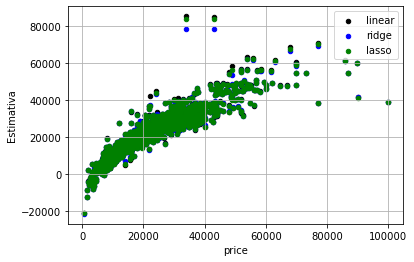

In [40]:
plt.figure()
idx = df_auto['train_set'] == 0
df_auto[idx].plot.scatter(target_col, 'linear', label='linear', color='k', ax=plt.gca())
df_auto[idx].plot.scatter(target_col, 'ridge', label='ridge', color='b', ax=plt.gca())
df_auto[idx].plot.scatter(target_col, 'lasso', label='lasso', color='g', ax=plt.gca())
# plt.gca().plot(df_auto[target_col],df_auto[target_col], 'ro', label='referência')
plt.grid()
plt.ylabel('Estimativa')

print('linear\t', metrics.mean_absolute_percentage_error(df_auto[idx][target_col], df_auto[idx]['linear']))
print('ridge\t', metrics.mean_absolute_percentage_error(df_auto[idx][target_col], df_auto[idx]['ridge']))
print('lasso\t', metrics.mean_absolute_percentage_error(df_auto[idx][target_col], df_auto[idx]['lasso']))

## Coeficientes do Modelo

In [41]:
from IPython.display import display

def plot_coefs(modelname):
    fig = plt.figure(figsize=(15,4))

    
    coefs = model_map[modelname].coef_
    coef_names = xtrain.columns

    idx = np.argsort(coefs)

    plt.bar(np.arange(coefs.shape[0]), coefs[idx])
    plt.xticks(np.arange(coefs.shape[0]), coef_names[idx], rotation='90')
    plt.title('Coeficientes do modelo '+ modelname)
    plt.grid()
    plt.xlim((-0.5, coefs.shape[0]-0.5))
    plt.show()

interact(plot_coefs, modelname = list(model_map.keys()))

interactive(children=(Dropdown(description='modelname', options=('linear', 'ridge', 'lasso'), value='linear'),…

<function __main__.plot_coefs(modelname)>

# Clima 

In [32]:
df_weather = pandas.read_csv('../Data/dataset_clima.csv',sep=';')

drop_cols = ['Temperature (C)']
df_weather.drop(drop_cols, axis=1, inplace=True)

print(df_weather.shape)

target_col = 'Apparent Temperature (C)'

df_weather.head()

(4019, 7)


,Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
0,-4.050000,0.890000,17.114300,140.000000,9.982000,0.0,1016.660000
1,-0.174537,0.817083,21.229192,142.750000,11.348487,0.0,1011.985000
2,1.808796,0.847083,17.824713,164.583333,8.492079,0.0,1010.384167
3,0.445370,0.897083,7.726658,252.541667,9.223958,0.0,1021.170833
4,-0.663194,0.906667,12.152817,35.000000,8.352546,0.0,981.770833


## Treinamento do Modelo 

In [33]:
model_map = {
    'linear': lm.LinearRegression(),
    'ridge': lm.Ridge(),
    'lasso': lm.Lasso()
}

Y = df_weather[target_col]
X = df_weather.drop(target_col, axis=1)

# train/test
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X, Y, test_size=0.2)

df_train = xtrain.copy()
df_test = xtest.copy()
df_train['train_set'] = 1
df_test['train_set'] = 0
df_train[target_col] = ytrain
df_test[target_col] = ytest

for modelname, model in model_map.items():
    model.fit(xtrain, ytrain)
    yhat_train = model.predict(xtrain)
    yhat_test  = model.predict(xtest)
    # Output table
    df_train[modelname] = yhat_train
    df_test[modelname] = yhat_test
    
df_weather = pandas.concat((df_train, df_test), axis=0)

## Resultados 

C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\envs\infnet\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\envs\infnet\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\envs\infnet\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\envs\infnet\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\envs\infnet\lib\site-packages\ipykerne

linear	 3.3336626046628006
ridge	 3.3481264630225107
lasso	 3.906125346720233


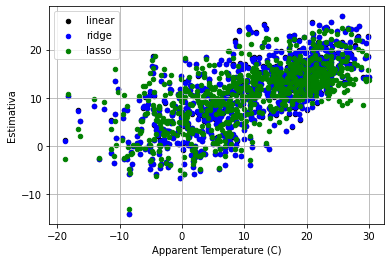

In [34]:
plt.figure()
idx = df_auto['train_set'] == 0
df_weather[idx].plot.scatter(target_col, 'linear', label='linear', color='k', ax=plt.gca())
df_weather[idx].plot.scatter(target_col, 'ridge', label='ridge', color='b', ax=plt.gca())
df_weather[idx].plot.scatter(target_col, 'lasso', label='lasso', color='g', ax=plt.gca())

plt.grid()
plt.ylabel('Estimativa')

print('linear\t', metrics.mean_absolute_percentage_error(df_weather[idx][target_col], df_weather[idx]['linear']))
print('ridge\t', metrics.mean_absolute_percentage_error(df_weather[idx][target_col], df_weather[idx]['ridge']))
print('lasso\t', metrics.mean_absolute_percentage_error(df_weather[idx][target_col], df_weather[idx]['lasso']))

## Coeficientes do Modelo 

In [35]:
interact(plot_coefs, modelname = list(model_map.keys()))

interactive(children=(Dropdown(description='modelname', options=('linear', 'ridge', 'lasso'), value='linear'),…

<function __main__.plot_coefs(modelname)>